In [63]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
import requests
import asdf
from astropy import log
from astropy import wcs
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import extract_array

import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table

from align_to_catalogs import *
import astropy.units as u

import align_to_catalogs
from jwst import assign_wcs#.util.update_fits_wcsinfo
from jwst.datamodels import ImageModel


<function jwst.assign_wcs.util.update_fits_wcsinfo(datamodel, max_pix_error=0.01, degree=None, npoints=32, crpix=None, projection='TAN', imwcs=None, **kwargs)>

In [54]:
wcs.WCS??

Init signature:
wcs.WCS(
    header=None,
    fobj=None,
    key=' ',
    minerr=0.0,
    relax=True,
    naxis=None,
    keysel=None,
    colsel=None,
    fix=True,
    translate_units='',
    _do_set=True,
)
Source:        
class WCS(FITSWCSAPIMixin, WCSBase):
    """WCS objects perform standard WCS transformations, and correct for
    `SIP`_ and `distortion paper`_ table-lookup transformations, based
    on the WCS keywords and supplementary data read from a FITS file.

    See also: https://docs.astropy.org/en/stable/wcs/

    Parameters
    ----------
    header : `~astropy.io.fits.Header`, `~astropy.io.fits.hdu.image.PrimaryHDU`, `~astropy.io.fits.hdu.image.ImageHDU`, str, dict-like, or None, optional
        If *header* is not provided or None, the object will be
        initialized to default values.

    fobj : `~astropy.io.fits.HDUList`, optional
        It is needed when header keywords point to a `distortion
        paper`_ lookup table stored in a different extension.

   

In [2]:
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [74]:
files = glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*destreak.fits")
files

['/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00001_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00002_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00001_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00003_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00003_nrcalong_destre

In [171]:
ref_image = '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak_copy.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak_realigned_to_vvv.fits'
file = '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00002_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00001_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits'
align_image = file.split('.')[0]+'_align.fits'
shutil.copy(file, align_image)

'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcblong_destreak_align.fits'

In [172]:
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data

In [173]:
pixel_scale = np.sqrt(fits.getheader(align_image, ext=1)['PIXAR_A2']*u.arcsec**2)
pixel_scale

<Quantity 0.06269025 arcsec>

In [174]:
align_image

'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcblong_destreak_align.fits'

2023-08-25 15:46:38,948 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:819: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-25T05:00:58.986' from MJD-BEG.
Set DATE-AVG to '2023-04-25T05:01:25.828' from MJD-AVG.
Set DATE-END to '2023-04-25T05:01:52.670' from MJD-END'.
  warnings.warn(

2023-08-25 15:46:38,951 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -119.979703 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.512404 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386427843.636 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-08-25 15:46:39,129 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:819: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:08:19.262' from MJD-BEG.
Set DATE-AVG to '2023-04-15T15:08:46.104' from MJD-AVG.
Set DATE-END to '2023-04-15T15:09:12.946' from MJD-END'.
  

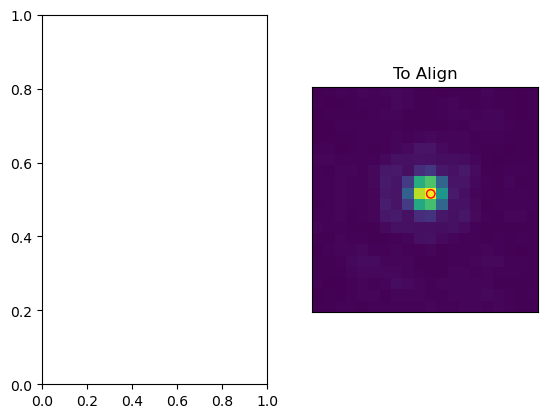

In [184]:
star_location = SkyCoord('17:46:24.5487598438','-28:34:55.0527112358',unit=(u.hourangle,u.deg))
#star_location = SkyCoord('17:46:21.8563090979','-28:32:09.7883394359',unit=(u.hourangle,u.deg))
#star_location = SkyCoord('17:46:17.9801892794','-28:32:00.4403815361',unit=(u.hourangle,u.deg))
#star_location = SkyCoord('17:46:22.4022124008','-28:37:38.6608645440',unit=(u.hourangle,u.deg))
#star_location = SkyCoord('17:46:15.2617658319','-28:37:31.4958546808',unit=(u.hourangle,u.deg))
shutil.copy(file, align_image)
#align_image = imfile#glob.glob('mastDownload/JWST/*long*/*cal.fits')[0]
align_fits = fits.open(align_image)
align_fits_wcs = wcs.WCS(fits.getheader(align_image, ext=1))
align_fits['SCI',1].header['CRPIX1']+=(3.85*u.arcsec/pixel_scale).value
align_fits['SCI',1].header['CRPIX2']+=(1*u.arcsec/pixel_scale).value
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

cutout_size=20.

#ref_cutout = extract_array(ref_data,(cutout_size,cutout_size),(ref_x,ref_y))
align_cutout = extract_array(align_data,(cutout_size,cutout_size),(align_x,align_y))
#norm1 = simple_norm(np.nan_to_num(ref_cutout), stretch='log', max_percent=99.95, log_a=1)#simple_norm(ref_cutout,stretch='linear',min_cut=-.5,max_cut=3)
norm2 = simple_norm(np.nan_to_num(align_cutout), stretch='log', max_percent=99.95, log_a=1)#simple_norm(align_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,2)
#axes[0].imshow(ref_cutout, origin='lower',
#                      norm=norm1)
#axes[0].scatter(cutout_size/2, cutout_size/2, edgecolor='r', facecolor='none')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2)
axes[1].scatter(cutout_size/2, cutout_size/2, edgecolor='r', facecolor='none')
#axes[0].set_title('Reference')
axes[1].set_title('To Align')
#axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()
